# Calculating 1+1 using quantum gates

The notebook use a quantum gates to 

1.  Calculating $1_{(10)}+1_{(10)}$ using quantum half adder: this section calculate...

2.  Quantum addtion using technics from paper:  [Vedral, V., Barenco, A., & Ekert, A. (1996)](https://doi.org/10.1103/PhysRevA.54.147)

3.  Calculating $5_{(10)}+3_{(10)}$ using quantum full adder: this section calculate...


## References

1.  Vedral, V., Barenco, A., & Ekert, A. (1996). Quantum networks for elementary arithmetic operations. Physical Review A, 54(1), 147–153. https://doi.org/10.1103/PhysRevA.54.147


## CNOT Gate (Controlled-NOT)

Let's first introduce `CNOT` gate truth table:

| Control (C) | Target Input (T) | Target Output (T $\oplus$ C) |
|-------------|------------------|------------------------|
| 0           | 0                | 0                      |
| 0           | 1                | 1                      |
| 1           | 0                | 1                      |
| 1           | 1                | 0                      |


## Toffoli Gate (CCX / Controlled-Controlled-NOT)

| Control 1 (C₁) | Control 2 (C₂) | Target Input (T) | Target Output (T ⊕ (C₁ $\cdot$ C₂)) |
|----------------|----------------|------------------|--------------------------------|
| 0              | 0              | 0                | 0                              |
| 0              | 0              | 1                | 1                              |
| 0              | 1              | 0                | 0                              |
| 0              | 1              | 1                | 1                              |
| 1              | 0              | 0                | 0                              |
| 1              | 0              | 1                | 1                              |
| 1              | 1              | 0                | 1                              |
| 1              | 1              | 1                | 0                              |

## Calculating $1_{(10)}+1_{(10)}$ using quantum half adder

Here we will start with a straightforward example of how to build a classical half adder by using quantum gates, specifically, only `CNOT` and `Toffoli` gate. We will use a 2-bit representation for better demonstration. Assume that we have $1_{(10)}$ that can be represented in binary form as 

$$
|a\rangle = |a_{1}a_{0}\rangle = |01\rangle,
$$

and 

$$
|b\rangle = |b_{1}b_{0}\rangle = |01\rangle.
$$


We introduce 2 extra qubits, `temp`, and `carry`:

1.  The `temp` qubit serve as a temporary storage of MSB of $b$, that is, $b_{1} = 0$. 
2.  The carry will be controlled by the addition of $a_{0}$ and `temp` by using the `Toffoli` gate. Below shows the assigned qubits.

This type of addition is basically made of two portions, sum and carry:

1.  The sum is computed by the addition of qubit $a_{0} \oplus b_{0}$, where $\oplus$ denotes a modulos 2 addtion.
2.  Carry is computed by the addition between $a_{0}$ and `temp` qubit.


In [215]:
# Qubit order:
# |a> = |a1a0>
# |b> = |b1b0>
# q[0] = a1
# q[1] = a0
# q[2] = b1
# q[3] = b0
# q[4] = temp
# q[5] = carry

> It's worth to notice that `Qiskit` default setting order for quantum state $|\text{MSB}...\text{LSB}\rangle$ is $|q_{0}q_{1}q_{2}\rangle$, this is easier for coding purpose since we starts our indexing from 0. Take Fourier transform, for example, `Qiskit` reverse the result at the end of the $\text{QFT}^{\dagger}$ to produce correct order we used to $|\text{MSB}...\text{LSB}\rangle$. 

> For example, without reversing the order, we get $5_{10} = |001_{2}\rangle$ after measurement since its in a order of $|q_{0}q_{1}q_{2}\rangle$ where we usually denote $5_{10} = 100$.

In [216]:
from qiskit import QuantumCircuit, ClassicalRegister
from qiskit import QuantumRegister

# Qubit order:
# q[0] = a1
# q[1] = a0
# q[2] = b1
# q[3] = b0
# q[4] = temp
# q[5] = carry

# initialize both quantum and classical registers and combine them to construct a initial quantum circuit
qr = QuantumRegister(6, name="q")
cr = ClassicalRegister(2, name="sum")
qc = QuantumCircuit(qr, cr, name="Adder_01+01")

# Initialize a = 01 → a1 = 0, a0 = 1s
qc.x(1)

# Initialize b = 01 → b1 = 0, b0 = 1
qc.x(3)

# Step 1: Save b0 to temp
qc.cx(3, 4)

# Step 2: CNOT(a0, b0) → sum₀
qc.cx(1, 3)

# Step 3: Toffoli(a0, temp, carry)
qc.ccx(1, 4, 5)

# Measure result: sum = b1b0
# carefully assign qubits to classical qubit, recall taht the order of classical bit is |cr_1,cr_0>!
qc.measure(qr[5], cr[1])  # b1 = 1 = c = cr[1]
qc.measure(qr[3], cr[0])  # b0 = 0 = sum = cr[0]

You will see that we set $q_{1} = q_{3} = |1\rangle$ to make $a_{1} = b_{1} = 1$ by plotting out our circuit!

Here, we measure the *carry* `qr[5]` and *sum* `qr[3]` and assign them into our classical register. Remember that our classical register is ordering as 

$$
|cr[1]cr[0]\rangle
$$

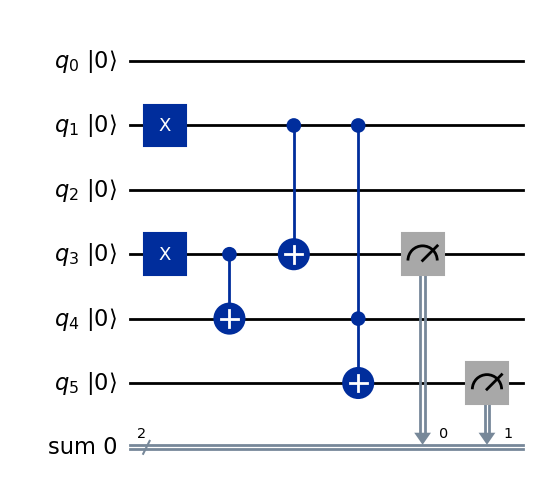

In [217]:
# Let's plot our circuit!
qc.draw('mpl', initial_state = True)

The following blocks is calling the Qiskit simulator and compute our measurement results using `StatevectorSampler` provided by Qiskit.

It's worth to notice that the `get_count()` function return classic register in a order of 

$$
|\text{cr}_{n-1}\text{cr}_{n-2}...\text{cr}_{1}\text{cr}_{0}\rangle
$$

**IF NO SPECIFIC ORDER IS ASSIGNED**

In [218]:
from qiskit.primitives import StatevectorSampler as Sampler
# --- Step 5: Execute with Aer Sampler ---
sampler = Sampler()
job = sampler.run([qc],shots=4096)
result = job.result()

print(result[0])

SamplerPubResult(data=DataBin(sum=BitArray(<shape=(), num_shots=4096, num_bits=2>)), metadata={'shots': 4096, 'circuit_metadata': {}})


In [219]:
# See our resutl
print(result[0].data)
print(result[0].data._data.keys())

DataBin(sum=BitArray(<shape=(), num_shots=4096, num_bits=2>))
dict_keys(['sum'])


In [220]:
# Extract dictionary key "sum"
bit_array = result[0].data['sum']
counts = bit_array.get_counts()

# Get our final resutls!
# Note that we have already assigned the classical bit order. We should get |10> as a result.
print(counts)

{'10': 4096}


Congratulations! You just implement a simple example of $1+1 = 2$ by using quantum gates! Now let's dive in into some concial method provide by paper:

*Vedral, V., Barenco, A., & Ekert, A. (1996). Quantum networks for elementary arithmetic operations. Physical Review A, 54(1), 147–153. https://doi.org/10.1103/PhysRevA.54.147*

## Quantum Networks for Elementary Arithmetic Operations

We have four basic elements here

1.  $|c_0\rangle$: Carry-in from previous bit, since we have nothing so this should be always $0$.
2.  $|a_0\rangle$: Single qubit a.
3.  $|b_0\rangle$: Single qubit b.
4.  $|c_1\rangle$: Carry-out based on sum of $a_0$ and $b_0$.

Since this type of circuit allows using addition on 2 qubits and take care of the carry-out. we'd say this is a full-adder. 

Same as before, we are trying to solve $1+1$ using quanutm arithmetic operations. Here, the qubit order of the inintal system state is labled as 

$$
|q_{0}q_{1}q_{2}q_{3}\rangle = |c_{0}a_{0}b_{0}c_{1}\rangle.
$$

In case of confusion, we need to assign the classical qubit when me measure the results to the order we are familir with, that is 

$$
|cr_{1}cr_{0}\rangle = |c_{1}b_{0}\rangle
$$

``` python
# Qubit order:
# q[0] = co
# q[1] = a0
# q[2] = b0
# q[3] = c1

Here let's consider the same $1+1 = |a_{0}\rangle + |b_{0}\rangle$ problem but using a different quantum circuit layout from *Vedral, V., Barenco, A., & Ekert, A. (1996). Quantum networks for elementary arithmetic operations. Physical Review A, 54(1), 147–153. https://doi.org/10.1103/PhysRevA.54.147*

It's worth to notice that the `get_count()` function return classic register in a order of 

$$
|\text{cr}_{n-1}\text{cr}_{n-2}...\text{cr}_{1}\text{cr}_{0}\rangle
$$

**IF NO SPECIFIC ORDER IS ASSIGNED**

See `get_coutns()`: [ https://docs.quantum.ibm.com/api/qiskit/qiskit.result.Result](https://docs.quantum.ibm.com/api/qiskit/qiskit.result.Result)

``` python
#get_coutns(): https://docs.quantum.ibm.com/api/qiskit/qiskit.result.Result
#The results are shown in the order that cr[0] on the right hand side.
#In this example, |cr[3]cr[2]cr[1]cr[0]> = |1010> which is what we want for the first 2 bits |cr[3]cr[2]> = |10>

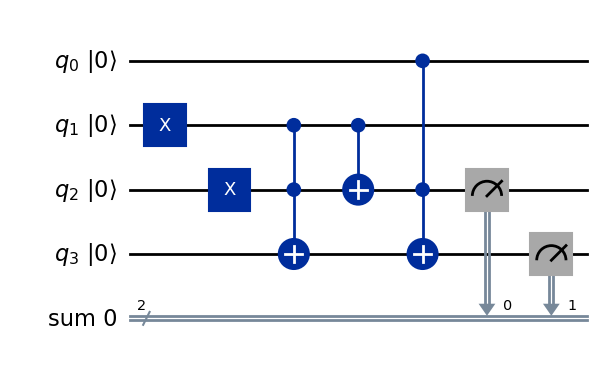

In [221]:
# Qubit order:
# q[0] = co
# q[1] = a0
# q[2] = b0
# q[3] = c1

# initialize both quantum and classical registers and combine them to construct a initial quantum circuit
qr = QuantumRegister(4, name="q")
cr = ClassicalRegister(2, name="sum")
qc = QuantumCircuit(qr, cr, name="Addeer")

# set a0 = b0 = |1>
qc.x([1,2])

qc.ccx(1, 2, 3)

qc.cx(1,2)

qc.ccx(0, 2, 3)

#qc.cx(0,2)
#qc.swap(2,3)

# get_coutns(): https://docs.quantum.ibm.com/api/qiskit/qiskit.result.Result
# The results are shown in the order that cr[0] on the right hand side.
# In this example, |cr[3]cr[2]cr[1]cr[0]> = |1010> which is what we want for the first 2 bits |cr[3]cr[2]> = |10>

# Measure result: sum = b1b0
qc.measure(qr[2], cr[0])  #sum
qc.measure(qr[3], cr[1])  #carry

qc.draw('mpl', initial_state = True, justify = 'none')

As you can see, we first put the state into $|1\rangle + |1\rangle$ by applying `X` gate to slip qubits from 0s to 1s. Then we apply the `Toffoli` gate with two control $a_0$ and $b_0$ with the target of $c_1$. 

Then we apply the `CNOT` to compute `sum`, which is the same as we have introduced before. By following the classic adder arithmetic,

$$
c_{1} = a \oplus b \oplus c_{0}.
$$

Finally, we apply a `CNOT` at the end of $b$ with `CNOT(c_0,b_0)` to calculate the final sum of $b$. Since $|q_0\rangle = 0$ thus in this case `CNOT(c_0,b_0)` = b.

In [ ]:
from qiskit.primitives import StatevectorSampler as Sampler
sampler = Sampler()
job = sampler.run([qc],shots=4096)
result = job.result()

print(result[0])

print(result[0].data)
print(result[0].data._data.keys())

bit_array = result[0].data['sum']
counts = bit_array.get_counts()

print(counts)

SamplerPubResult(data=DataBin(sum=BitArray(<shape=(), num_shots=4096, num_bits=2>)), metadata={'shots': 4096, 'circuit_metadata': {}})
DataBin(sum=BitArray(<shape=(), num_shots=4096, num_bits=2>))
dict_keys(['sum'])
{'10': 4096}


Congratulations! You just implement a simple example of $1+1 = 2$ by following the paper from *Vedral*!

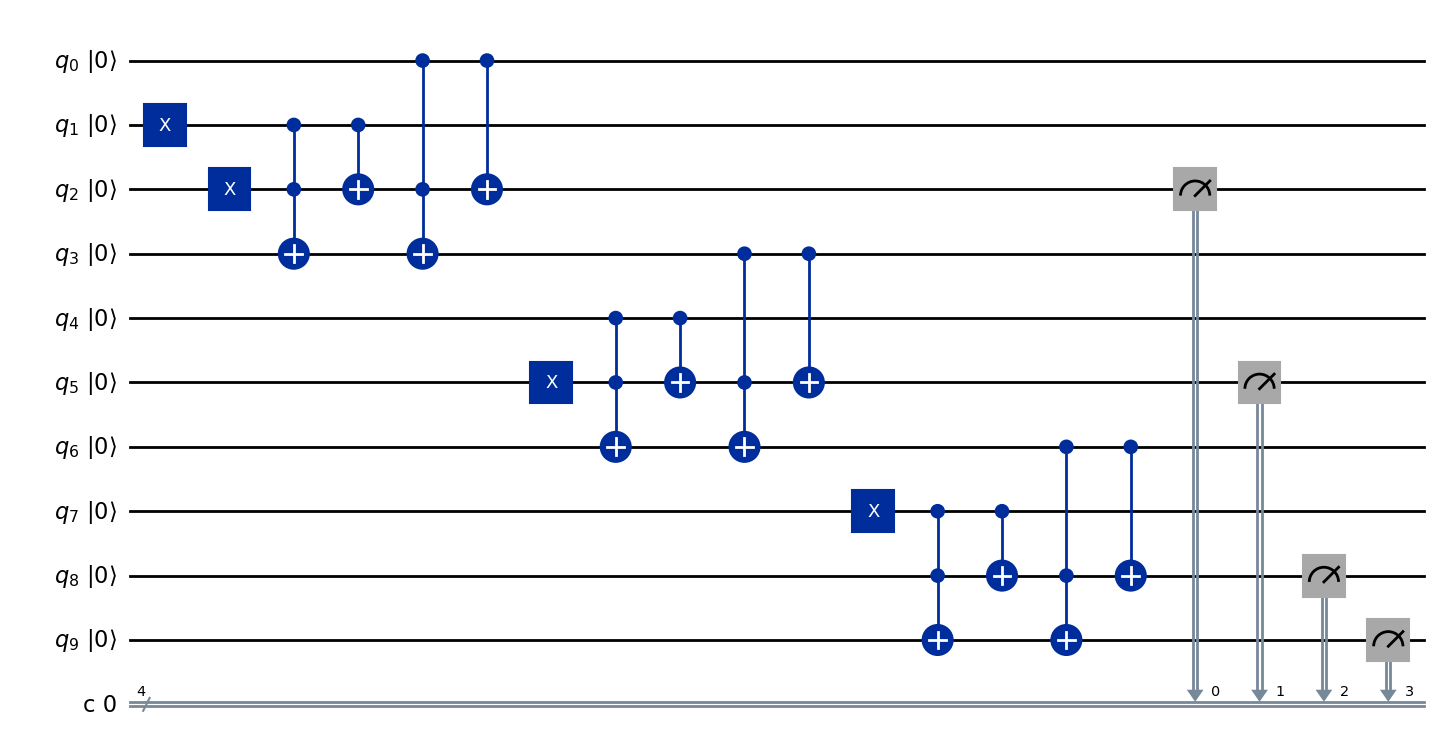

In [223]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

qr = QuantumRegister(10, 'q')
cr = ClassicalRegister(4, 'c')  # sum0, sum1, sum2, carry_out
qc = QuantumCircuit(qr, cr)

n = 3

# a = 101, a2a1a0
qc.x(1)
qc.x(7)

# b = 011, b2b1b0
qc.x(2)
qc.x(5)

for i in range(3):  # 3-bit adder
    base = i * 3  # step by 3 (since c overlaps)
    #print(i)
    c_in  = base + 0
    a     = base + 1
    b     = base + 2
    c_out = base + 3

    # print(c_in, a, b, c_out)

    qc.ccx(a, b, c_out)     # first carry term
    qc.cx(a, b)             # xor
    qc.ccx(c_in, b, c_out)  # second carry term
    qc.cx(c_in, b)          # final sum in b

    # Measure b0, b1, b2 and carry_out
    qc.measure(b, i)  # sum0
    if i == 2:
        qc.measure(c_out, i+1)  # final carry_out (c3)


qc.draw('mpl', initial_state = True, justify = 'none')


In [224]:
from qiskit.primitives import StatevectorSampler as Sampler
# --- Step 5: Execute with Aer Sampler ---
sampler = Sampler()
job = sampler.run([qc],shots=4096)
result = job.result()

print(result[0])

print(result[0].data)
print(result[0].data._data.keys())

bit_array = result[0].data['c']
counts = bit_array.get_counts()

print(counts)

SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=4096, num_bits=4>)), metadata={'shots': 4096, 'circuit_metadata': {}})
DataBin(c=BitArray(<shape=(), num_shots=4096, num_bits=4>))
dict_keys(['c'])
{'1000': 4096}


## A more useful way (Reversible variation)

Most of time, we want our circuit be reversieble for more practical applications

$$
|a,b\rangle \rightarrow |a,a+b\rangle
$$

we apply carries gates then 

0 1 2 3
3 4 5 6
6 7 8 9


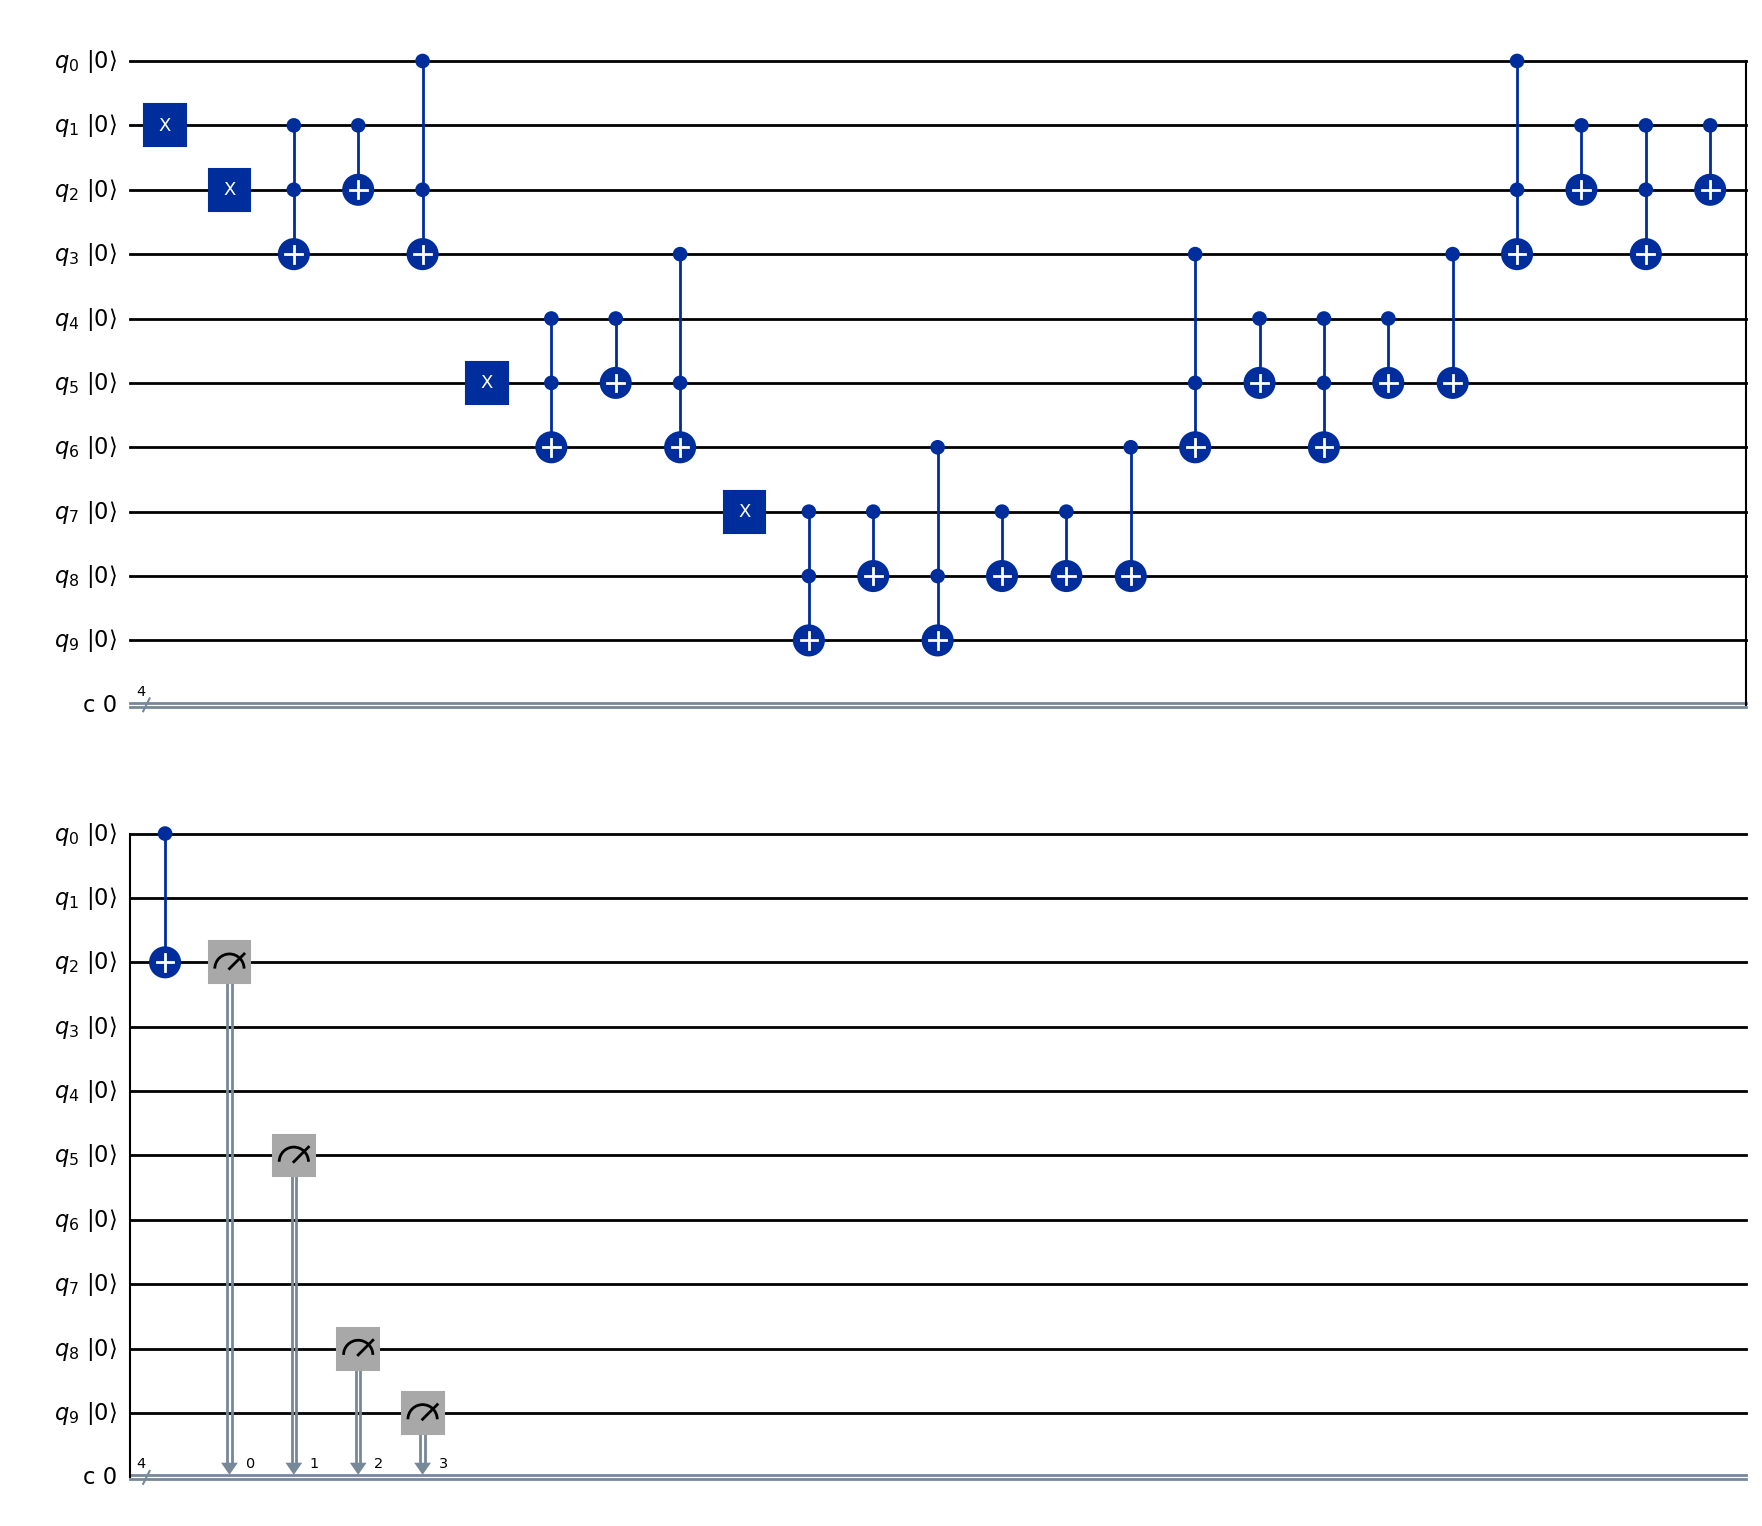

In [225]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

qr = QuantumRegister(10, 'q')
cr = ClassicalRegister(4, 'c')  # sum0, sum1, sum2, carry_out
qc = QuantumCircuit(qr, cr)

n = 3

# a = 101, a2a1a0
qc.x(1)
qc.x(7)

# b = 011, b2b1b0
qc.x(2)
qc.x(5)

for i in range(n):  # 3-bit adder
    base = i * 3  # step by 3 (since c overlaps)
    #print(i)
    c_in  = base + 0
    a     = base + 1
    b     = base + 2
    c_out = base + 3

    print(c_in, a, b, c_out)

    qc.ccx(a, b, c_out)     # first carry term
    qc.cx(a, b)             # xor
    qc.ccx(c_in, b, c_out)  # second carry term
    #qc.cx(c_in, b)          # final sum in b

    # Measure b0, b1, b2 and carry_out
    #qc.measure(b, i)  # sum0
    #qc.measure(c_out, i+1)  # final carry_out (c3)
    if i == 2:
        qc.measure(c_out, i+1)  # final carry_out (c3)

a_n = n * 3 - 2
b_n = n * 3 - 1
qc.cx(a_n,b_n)

# sum gate
c_n_1 = n * 2
qc.cx(a_n,b_n)
qc.cx(c_n_1,b_n)
qc.measure(b_n, i)  # sum0

for i in reversed(range(n-1)):
    base = i * 3  # step by 3 (since c overlaps)
    #print(i)
    c_in  = base + 0
    a     = base + 1
    b     = base + 2
    c_out = base + 3

    # Carry in reverse order 
    qc.ccx(c_in, b, c_out)  # second carry term
    qc.cx(a, b)             # xor
    qc.ccx(a, b, c_out)     # first carry term

    qc.cx(a,b)
    qc.cx(c_in,b)
    qc.measure(b, i)  # sum0
    



qc.draw('mpl', initial_state = True, justify = 'none')

Again, we assign a classcial register order to reduce confusion, result should be shown as 

$$
|\text{cr}_{3}\text{cr}_{2}\text{cr}_{1}\text{cr}_{0}\rangle = |1000_{2}\rangle = |8_{10}\rangle
$$

since function `get_counts()` already swap the order for us. How nice! 😃

In [226]:
from qiskit.primitives import StatevectorSampler as Sampler
# --- Step 5: Execute with Aer Sampler ---
sampler = Sampler()
job = sampler.run([qc],shots=4096)
result = job.result()

print(result[0])

print(result[0].data)
print(result[0].data._data.keys())

bit_array = result[0].data['c']
counts = bit_array.get_counts()

print(counts)

SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=4096, num_bits=4>)), metadata={'shots': 4096, 'circuit_metadata': {}})
DataBin(c=BitArray(<shape=(), num_shots=4096, num_bits=4>))
dict_keys(['c'])
{'1000': 4096}


Wonderful!🏆🥇 You already expertised in implementing an full adder in a quantum plus the practical way! Let's keep learning!✌️